# ***Important Libraby***

In [ ]:
import os
import math
import datetime
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, BatchNormalization,
                                     GlobalAveragePooling2D, Dense, Dropout)
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                        ReduceLROnPlateau, TensorBoard)
from PIL import ImageFile
import kagglehub  # you already used this

warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.get_logger().setLevel('ERROR')

In [ ]:
DOWNLOAD = False
DATA_ROOT = "/root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1"  # change if different
MODEL_DIR = "saved_model"
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
IM_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 5
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

TRAIN_SUBDIR = "train"
VALID_SUBDIR = "valid"
TEST_SUBDIR = "test"

# ***Load*** ***DataSet***

In [ ]:
import os
import kagglehub

# Download dataset (root folder)
DATA_ROOT = kagglehub.dataset_download("abdelghaniaaba/wildfire-prediction-dataset")
print("Dataset stored at:", DATA_ROOT)

# Define subfolders
train_path = os.path.join(DATA_ROOT, "train")
valid_path = os.path.join(DATA_ROOT, "valid")
test_path  = os.path.join(DATA_ROOT, "test")

# Safety check
for p in (train_path, valid_path, test_path):
    if not os.path.isdir(p):
        print("⚠️ Warning: expected directory missing:", p)

# Quick look at structure
for root, dirs, files in os.walk(DATA_ROOT):
    print(root, len(files), "files")


100%|██████████| 1.45G/1.45G [00:12<00:00, 120MB/s]

Extracting files...


Dataset stored at: /root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1
/root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1 0 files
/root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1/test 0 files
/root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1/test/nowildfire 2820 files
/root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1/test/wildfire 3480 files
/root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1/valid 0 files
/root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1/valid/nowildfire 2820 files
/root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1/valid/wildfire 3480 files
/root/.cache/kagglehub/datasets/abdelghaniaaba/wildfire-prediction-dataset/versions/1/train 0 files
/root/.cache/kagglehub/datasets/abdelghaniaaba/wildf

# ***Pre-Processing The Data***

In [ ]:
# Data augmentation for training to improve generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    shear_range=0.05,
    fill_mode='nearest'
)

In [ ]:
# Validation/test: only rescale
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

Found 30250 images belonging to 2 classes.


In [ ]:
valid_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

Found 6300 images belonging to 2 classes.


In [ ]:
test_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

class_mapping = train_generator.class_indices
print("Class mapping:", class_mapping)
class_names = list(class_mapping.keys())

Found 6300 images belonging to 2 classes.
Class mapping: {'nowildfire': 0, 'wildfire': 1}


# ***Class Distribution Plot***

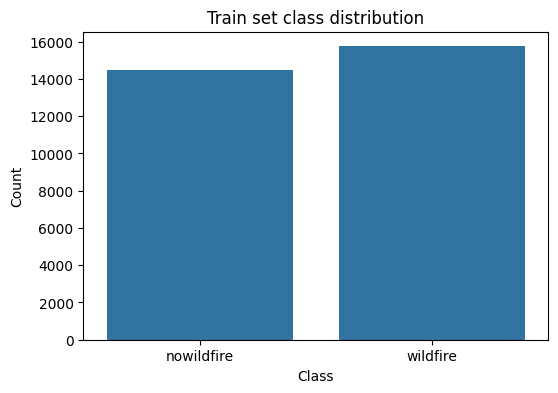

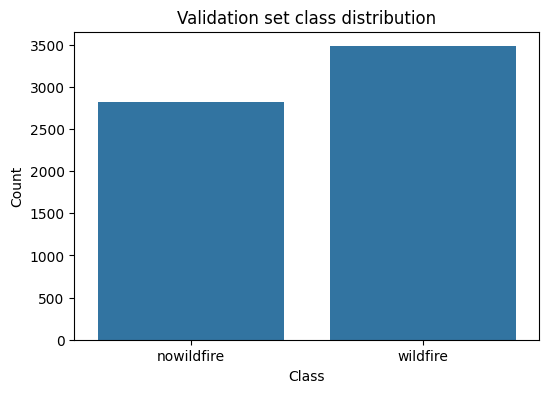

In [ ]:
# Quick class distribution plots
def plot_class_distribution(generator, title="Class distribution"):
    labels = generator.classes
    unique, counts = np.unique(labels, return_counts=True)
    counts_by_class = {class_names[int(u)]: int(c) for u, c in zip(unique, counts)}
    df = pd.DataFrame({"Class": list(counts_by_class.keys()), "Count": list(counts_by_class.values())})
    plt.figure(figsize=(6,4))
    sns.barplot(x='Class', y='Count', data=df)
    plt.title(title)
    plt.show()

plot_class_distribution(train_generator, "Train set class distribution")
plot_class_distribution(valid_generator, "Validation set class distribution")

# ***Model Building***

In [ ]:
# --------------------- Model builder -----------------------
def conv_block(x, filters, kernel=3, pool=True, dropout_rate=0.0):
    x = Conv2D(filters, kernel, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    if pool:
        x = MaxPool2D(2)(x)
    if dropout_rate and dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    return x

def build_custom_cnn(input_shape=(IM_SIZE, IM_SIZE, 3), num_classes=NUM_CLASSES):
    inp = Input(shape=input_shape, name='input')
    x = conv_block(inp, 32, pool=True)
    x = conv_block(x, 64, pool=True)
    x = conv_block(x, 128, pool=True)
    x = conv_block(x, 256, pool=True)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    out = Dense(num_classes, activation='softmax', name='class_out')(x)
    model = Model(inputs=inp, outputs=out, name='firenet')
    return model

In [ ]:
# If you prefer transfer learning, here's a simple MobileNetV2 option:
def build_mobilenetv2(input_shape=(IM_SIZE, IM_SIZE, 3), num_classes=NUM_CLASSES, freeze_backbone=True):
    base = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    if freeze_backbone:
        base.trainable = False
    x = Input(shape=input_shape)
    z = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    z = base(z, training=False)
    z = GlobalAveragePooling2D()(z)
    z = Dropout(0.3)(z)
    out = Dense(num_classes, activation='softmax')(z)
    model = Model(inputs=x, outputs=out, name='mobilenetv2_fire')
    return model

# ***Choose model***

In [ ]:
# Choose model: custom CNN or mobilenet
USE_TRANSFER = True

if USE_TRANSFER:
    model = build_mobilenetv2()
else:
    model = build_custom_cnn()

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_fire"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
lr = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
best_model_path = os.path.join(MODEL_DIR, f"best_model_{timestamp}.h5")

callbacks = [
    ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    TensorBoard(log_dir=os.path.join("logs", timestamp))
]

# ***Train the Data***

In [ ]:
# ------------------------- Training ---------------------------
steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)
validation_steps = math.ceil(valid_generator.samples / BATCH_SIZE)

print(f"Training steps_per_epoch={steps_per_epoch}, validation_steps={validation_steps}")

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Training steps_per_epoch=946, validation_steps=197
Epoch 1/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5552 - loss: 0.7306
Epoch 1: val_accuracy improved from -inf to 0.85952, saving model to saved_model/best_model_20250914-190040.h5


946/946 ━━━━━━━━━━━━━━━━━━━━ 2033s 2s/step - accuracy: 0.5552 - loss: 0.7305 - val_accuracy: 0.8595 - val_loss: 0.5094 - learning_rate: 1.0000e-04
Epoch 2/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7369 - loss: 0.5497
Epoch 2: val_accuracy improved from 0.85952 to 0.86556, saving model to saved_model/best_model_20250914-190040.h5


946/946 ━━━━━━━━━━━━━━━━━━━━ 2029s 2s/step - accuracy: 0.7369 - loss: 0.5497 - val_accuracy: 0.8656 - val_loss: 0.4317 - learning_rate: 1.0000e-04
Epoch 3/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8051 - loss: 0.4763
Epoch 3: val_accuracy improved from 0.86556 to 0.87143, saving model to saved_model/best_model_20250914-190040.h5


946/946 ━━━━━━━━━━━━━━━━━━━━ 1974s 2s/step - accuracy: 0.8051 - loss: 0.4763 - val_accuracy: 0.8714 - val_loss: 0.4004 - learning_rate: 1.0000e-04
Epoch 4/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8315 - loss: 0.4426
Epoch 4: val_accuracy improved from 0.87143 to 0.87254, saving model to saved_model/best_model_20250914-190040.h5


946/946 ━━━━━━━━━━━━━━━━━━━━ 1884s 2s/step - accuracy: 0.8315 - loss: 0.4426 - val_accuracy: 0.8725 - val_loss: 0.3803 - learning_rate: 1.0000e-04
Epoch 5/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8384 - loss: 0.4188
Epoch 5: val_accuracy did not improve from 0.87254
946/946 ━━━━━━━━━━━━━━━━━━━━ 1927s 2s/step - accuracy: 0.8384 - loss: 0.4188 - val_accuracy: 0.8725 - val_loss: 0.3665 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.


# ***Evaluate***

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



# Save final model
# final_model_path = os.path.join(MODEL_DIR, f"final_model.keras")
# model.save(final_model_path)
# print("Saved final model to:", final_model_path)

In [ ]:
loss,accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

197/197 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.8326 - loss: 0.3725
Test Accuracy: 0.8770
Test Loss: 0.3577


# ***Model Save***

In [ ]:
model.save("Fire_detection.keras")

In [ ]:
import os
import math
import tensorflow as tf
from tensorflow.keras.models import load_model

# Pick the best model if available, else final model
best_model_path = os.path.join(MODEL_DIR, f"best_model_{timestamp}.h5")
final_model_path = os.path.join(MODEL_DIR, f"final_model.h5")

best_model_to_eval = best_model_path if os.path.exists(best_model_path) else final_model_path
print("Evaluating with model:", best_model_to_eval)

# Rebuild the model architecture and load weights
# Assuming the build_mobilenetv2 function is available from a previous cell
model_eval = build_mobilenetv2() # Rebuild the model architecture
model_eval.load_weights(best_model_to_eval) # Load the saved weights

# Compile the model
# We need to compile the model before evaluating it
model_eval.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


# Evaluate on test data
import math

test_steps = math.ceil(test_generator.samples / BATCH_SIZE)
loss, acc = model_eval.evaluate(test_generator, steps=test_steps, verbose=1)

print(f"\n✅ Test Accuracy: {acc:.4f}")
print(f"✅ Test Loss: {loss:.4f}")

Evaluating with model: saved_model/best_model_20250914-064812.h5
197/197 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.8344 - loss: 0.3739

✅ Test Accuracy: 0.8775
✅ Test Loss: 0.3708
